<a href="https://colab.research.google.com/github/rohhj622/windPowerPrediction/blob/master/code1_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 데이터 불러오기

In [20]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import seaborn as sns
from datetime import datetime

from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn import model_selection
from keras import models, layers, Sequential
from keras.layers import LSTM, Dropout, Dense, Activation, Input, SimpleRNN

## 1) 구글 드라이브 연결

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


## 3) 데이터 불러오기 시작

In [3]:
allData = pd.read_csv(r'/content/gdrive/My Drive/Colab Notebooks/preprocessing_Data.csv') # 컬럼명 숫자로 들어가게
allData = allData.drop('Unnamed: 0',1)
allData

,datetime,date,time,windForce,tem,windSpeed,windDirect,humidity,vaporPressure,dewPoint,pressure,seaLevelPressure,groundTem
0,2013-01-01 00:00:00,2013-01-01 00:00:00,00:00,0,1.3,3.2,340,77.0,5.2,-2.2,1019.1,1021.3,0.0
1,2013-01-01 01:00:00,2013-01-01 00:00:00,01:00,0,0.9,2.6,320,77.0,5.0,-2.6,1019.0,1021.2,0.0
2,2013-01-01 02:00:00,2013-01-01 00:00:00,02:00,92,1.5,3.0,340,77.0,5.2,-2.1,1019.0,1021.2,0.0
3,2013-01-01 03:00:00,2013-01-01 00:00:00,03:00,269,2.7,1.7,270,74.0,5.5,-1.4,1019.0,1021.2,0.3
4,2013-01-01 04:00:00,2013-01-01 00:00:00,04:00,541,0.6,1.8,320,82.0,5.2,-2.1,1018.5,1020.8,0.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
52579,2018-12-31 19:00:00,2018-12-31 00:00:00,19:00,8699,4.3,4.7,340,58.0,4.8,-3.2,1032.1,1034.7,3.3
52580,2018-12-31 20:00:00,2018-12-31 00:00:00,20:00,10694,3.9,4.5,360,61.0,4.9,-2.9,1032.0,1034.6,2.9
52581,2018-12-31 21:00:00,2018-12-31 00:00:00,21:00,5494,3.5,4.0,360,59.0,4.6,-3.7,1031.9,1034.5,1.9
52582,2018-12-31 22:00:00,2018-12-31 00:00:00,22:00,2718,3.8,3.4,20,61.0,4.9,-3.0,1031.6,1034.2,2.1


# 2. 데이터 가공하기 

## 1) datetime 컬럼 제작, datetime 형식으로 변환

In [4]:
df = allData.copy()
df['datetime'] = pd.to_datetime(df['datetime'],format='%Y-%m-%d %H:%M', errors='ignore') #합친거 datetime 형식으로 변환
df['date'] = pd.to_datetime(df['date'],format='%Y-%m-%d', errors='ignore')  #date형식으로 변환
#df['time'] = pd.to_datetime(df['time'],format='%H:%M', errors='ignore') #time 형식으로 변환
df.head(5)

,datetime,date,time,windForce,tem,windSpeed,windDirect,humidity,vaporPressure,dewPoint,pressure,seaLevelPressure,groundTem
0,2013-01-01 00:00:00,2013-01-01,00:00,0,1.3,3.2,340,77.0,5.2,-2.2,1019.1,1021.3,0.0
1,2013-01-01 01:00:00,2013-01-01,01:00,0,0.9,2.6,320,77.0,5.0,-2.6,1019.0,1021.2,0.0
2,2013-01-01 02:00:00,2013-01-01,02:00,92,1.5,3.0,340,77.0,5.2,-2.1,1019.0,1021.2,0.0
3,2013-01-01 03:00:00,2013-01-01,03:00,269,2.7,1.7,270,74.0,5.5,-1.4,1019.0,1021.2,0.3
4,2013-01-01 04:00:00,2013-01-01,04:00,541,0.6,1.8,320,82.0,5.2,-2.1,1018.5,1020.8,0.1


## 2) 년(year), 월(month), 일(day), 계절(season) 컬럼 생성



In [5]:
df['year'] = df['date'].dt.year # 년
df['month'] = df['date'].dt.month # 월
df['day'] = df['date'].dt.day# 일

conditionlist = [
    (df['month'] == 3)|(df['month'] == 4)| (df['month'] == 5) ,
    (df['month'] == 6)|(df['month'] == 7)|(df['month'] == 8) ,
    (df['month'] == 9)|(df['month'] == 10)|(df['month'] == 11),
    (df['month'] == 12)|(df['month'] == 1)|(df['month'] == 2) ]
choicelist = ['0', '1', '2','3']
#choicelist = ['spring', 'summer', 'autumn','winter']
df['season'] = np.select(conditionlist, choicelist, default='Not Specified')
df.head(5)

,datetime,date,time,windForce,tem,windSpeed,windDirect,humidity,vaporPressure,dewPoint,pressure,seaLevelPressure,groundTem,year,month,day,season
0,2013-01-01 00:00:00,2013-01-01,00:00,0,1.3,3.2,340,77.0,5.2,-2.2,1019.1,1021.3,0.0,2013,1,1,3
1,2013-01-01 01:00:00,2013-01-01,01:00,0,0.9,2.6,320,77.0,5.0,-2.6,1019.0,1021.2,0.0,2013,1,1,3
2,2013-01-01 02:00:00,2013-01-01,02:00,92,1.5,3.0,340,77.0,5.2,-2.1,1019.0,1021.2,0.0,2013,1,1,3
3,2013-01-01 03:00:00,2013-01-01,03:00,269,2.7,1.7,270,74.0,5.5,-1.4,1019.0,1021.2,0.3,2013,1,1,3
4,2013-01-01 04:00:00,2013-01-01,04:00,541,0.6,1.8,320,82.0,5.2,-2.1,1018.5,1020.8,0.1,2013,1,1,3


# 4. 훈련 & 예측

## 1) train-test data 나누기

In [6]:
df2 = df.copy()
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52584 entries, 0 to 52583
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   datetime          52584 non-null  datetime64[ns]
 1   date              52584 non-null  datetime64[ns]
 2   time              52584 non-null  object        
 3   windForce         52584 non-null  int64         
 4   tem               52584 non-null  float64       
 5   windSpeed         52584 non-null  float64       
 6   windDirect        52584 non-null  int64         
 7   humidity          52584 non-null  float64       
 8   vaporPressure     52584 non-null  float64       
 9   dewPoint          52584 non-null  float64       
 10  pressure          52584 non-null  float64       
 11  seaLevelPressure  52584 non-null  float64       
 12  groundTem         52584 non-null  float64       
 13  year              52584 non-null  int64         
 14  month             5258

In [34]:
X = df2[['tem','windSpeed','windDirect','humidity']] #,'groundTem','seaLevelPressure'
y = df2[['windForce']]

transform = MinMaxScaler()
trans_X=transform.fit_transform(X)
trans_y=transform.fit_transform(y)

X_train, X_test,y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=10)
print('train data 개수 : ', len(X_train))
print('test data 개수: ', len(X_test))
print(len(X_train)+len(X_test))

train data 개수 :  42067
test data 개수:  10517
52584


In [36]:
X_train.ndim
X_train.shape

(42067, 4)

## 5. LSTM !!!


In [95]:
# https://teddylee777.github.io/tensorflow/LSTM%EC%9C%BC%EB%A1%9C-%EC%98%88%EC%B8%A1%ED%95%B4%EB%B3%B4%EB%8A%94-%EC%82%BC%EC%84%B1%EC%A0%84%EC%9E%90-%EC%A3%BC%EA%B0%80
def make_dataset(data, label, window_size=1):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

In [107]:
# X = df2[['tem','windSpeed','humidity','groundTem','windDirect','seaLevelPressure']] #,'windDirect'
# X = df2[['tem','windSpeed','groundTem']] #,'windDirect'
transform = MinMaxScaler()

scale_cols=['tem','windSpeed','groundTem','windForce']
df_scaled = df2[['tem','windSpeed','groundTem','windForce']] 
df_scaled = transform.fit_transform(df_scaled)
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

train = df_scaled[:int(len(df2)*0.8)]
test = df_scaled[int(len(df2)*0.8):]
print(train.head())
print(test.head())

        tem  windSpeed  groundTem  windForce
0  0.190123   0.180791   0.061135   0.000000
1  0.180247   0.146893   0.061135   0.000000
2  0.195062   0.169492   0.061135   0.007663
3  0.224691   0.096045   0.065502   0.022407
4  0.172840   0.101695   0.062591   0.045065
            tem  windSpeed  groundTem  windForce
42067  0.607407   0.158192   0.312955   0.144940
42068  0.585185   0.062147   0.305677   0.111370
42069  0.565432   0.067797   0.298399   0.079967
42070  0.558025   0.073446   0.292576   0.061808
42071  0.562963   0.079096   0.289665   0.055560


In [108]:
WINDOW_SIZE = 1 # 일 데이터를 묶을지 (window_size : 20, 1)
feature1 = ['tem','windSpeed','groundTem','windForce']
labels1 = ['windForce']

train_feature = train[feature1]
train_label = train[labels1]

train_feature, train_label = make_dataset(train_feature, train_label, WINDOW_SIZE)

X_train, X_valid,y_train, y_valid = train_test_split(train_feature,train_label,test_size=0.2,random_state=10) # train, valid
print(X_train.shape, X_valid.shape)

(33652, 1, 4) (8414, 1, 4)


In [109]:
test_feature = test[feature1]
test_label = test[labels1]
test_feature, test_label = make_dataset(test_feature, test_label, WINDOW_SIZE)
test_feature.shape, test_label.shape

((10516, 1, 4), (10516, 1))

In [110]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM
import os

model = Sequential()
model.add(LSTM(16, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )
model.add(Dense(8))
model.add(Dense(1))

# network.add(layers.Dense(128, input_shape=train_feature.shape,activation='relu'))
# network.add(layers.Dense(64,activation='relu'))
# network.add(layers.Dense(1))

In [111]:
model.compile(loss='binary_crossentropy', optimizer='rmsprop')
early_stop = EarlyStopping(monitor='val_loss', patience=5)
model_path = '/content/gdrive/My Drive/Colab Notebooks'
filename = os.path.join(model_path, 'tmp_checkpoint.h5')
print(filename)
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(X_train, y_train, 
                    epochs=200, 
                    batch_size=16,
                    validation_data=(X_valid, y_valid), 
                    callbacks=[early_stop, checkpoint])


/content/gdrive/My Drive/Colab Notebooks/tmp_checkpoint.h5
Epoch 1/200
2104/2104 [==============================] - 5s 1ms/step - loss: 0.4605 - val_loss: 0.3847

Epoch 00001: val_loss improved from inf to 0.38471, saving model to /content/gdrive/My Drive/Colab Notebooks/tmp_checkpoint.h5
Epoch 2/200
2104/2104 [==============================] - 3s 1ms/step - loss: 0.3844 - val_loss: 0.3824

Epoch 00002: val_loss improved from 0.38471 to 0.38240, saving model to /content/gdrive/My Drive/Colab Notebooks/tmp_checkpoint.h5
Epoch 3/200
2104/2104 [==============================] - 3s 1ms/step - loss: 0.3820 - val_loss: 0.3818

Epoch 00003: val_loss improved from 0.38240 to 0.38176, saving model to /content/gdrive/My Drive/Colab Notebooks/tmp_checkpoint.h5
Epoch 4/200
2104/2104 [==============================] - 3s 1ms/step - loss: 0.3827 - val_loss: 0.3816

Epoch 00004: val_loss improved from 0.38176 to 0.38159, saving model to /content/gdrive/My Drive/Colab Notebooks/tmp_checkpoint.h5
Epoch

In [112]:
# weight 로딩
model.load_weights(filename)

# 예측
pred = model.predict(test_feature)

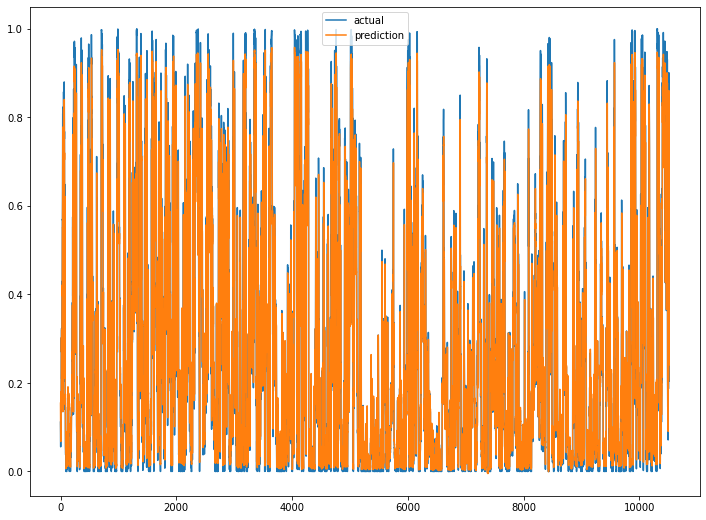

In [113]:
plt.figure(figsize=(12, 9))
plt.plot(test_label, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


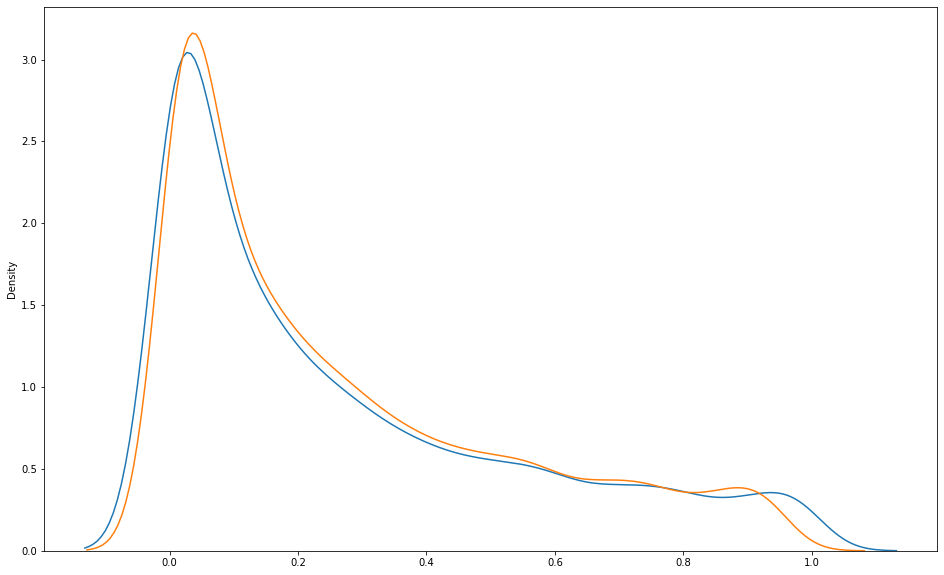

In [114]:
plt.figure(figsize=(16,10))
ax1 = sns.distplot(test_label,hist=False,label='y')
ax2 = sns.distplot(pred,hist=False,label='y_hat',ax=ax1)

plt.show()
plt.close()

In [115]:
test_label

array([[0.11137026],
       [0.07996668],
       [0.06180758],
       ...,
       [0.45764265],
       [0.22640566],
       [0.20474802]])

In [116]:
 pred

array([[0.15425524],
       [0.12303162],
       [0.09175117],
       ...,
       [0.8508988 ],
       [0.45513296],
       [0.24135481]], dtype=float32)